# Using Spark to Predict Churn

This project will serve as an exploration of how to make a churn-prediction model using Spark, with the following steps included:
- explore and manipulate our dataset
- engineer relevant features for our problem
- split data into train and test sets by sampling churn
- build binary classifier models with Spark's DataFrame-based MLlib
- select and fine-tune the final model with Spark's ML Pipelines and a StratifiedCrossValidator

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml import feature as FT
from pyspark.ml.tuning import ParamGridBuilder
from spark_stratifier import StratifiedCrossValidator
from pyspark.ml.evaluation import Evaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

import time
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

# Load and Clean Dataset

## Load Data

In [3]:
user_log = spark.read.json('mini_sparkify_event_data.json')

In [4]:
user_log.count()

286500

In [5]:
user_log.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Clean Data

### Check Missing/Null/Empty Values

No NaN values in all columns.

In [7]:
# check: NaN values per column
count_nan_cols = [F.count(F.when(F.isnan(c), c)).alias(c) for c in user_log.columns]
user_log.select(count_nan_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Null values are found in columns related with user information and song information.

In [8]:
# check: null values per column
count_null_cols = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in user_log.columns]
user_log.select(count_null_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


Pages that are not `NextSong` will have null values for `artist`, `length` and `song`. 

In [9]:
user_log.filter(F.col('artist').isNull()).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,None,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Logged In,Micah,M,84,Long,None,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,None,Logged In,Micah,M,86,Long,None,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Alexi,F,4,Warren,None,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
4,None,Logged In,Alexi,F,7,Warren,None,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54


In [10]:
user_log.filter(F.col('artist').isNull()).select('page').dropDuplicates().sort('page').show(30, False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Login                    |
|Logout                   |
|Register                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Registration      |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



In [11]:
user_log.filter(F.col('artist').isNull()!=True).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [12]:
user_log.filter(F.col('artist').isNull()!=True).select('page').dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



In [13]:
# check: empty values per column
count_invalid_cols = [F.count(F.when(F.col(c)=='', c)).alias(c) for c in user_log.columns]
user_log.select(count_invalid_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8346


Users with empty `userId` are those who did not register and log in.

In [14]:
user_log.filter(F.col('userId')=='').toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,None,free,None,GET,Home,None,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,None,free,None,GET,Help,None,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,None,free,None,GET,Home,None,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,None,free,None,PUT,Login,None,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,None,free,None,GET,Home,None,240,None,200,1538356678000,None,


In [15]:
user_log.filter(F.col('userId')=='').groupBy('registration', 'auth').count().toPandas()

,registration,auth,count
0,None,Logged Out,8249
1,None,Guest,97


### Drop rows with empty userId

Since logs with empty `userId` can’t help us identify the users behind, we can’t make predictions for them. So we drop them from our analysis.

In [16]:
df = user_log.filter(F.col('userId')!='')
df.count()

278154

# Exploratory Data Analysis
*When working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within local Spark.

## Define Churn
Use the `Cancellation Confirmation` event to define churn. Churned users will have a `1` in the column `churn`, the label column for our model.

In [17]:
flag_churn = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, T.IntegerType())
df = df.withColumn('churn', flag_churn('page'))

## Transform Data

Transform the original dataset (one row per log) to a dataset with user-level information or statistics (one row per user).

### Convert Timestamps (ms) to Datetime

In [18]:
df = df.withColumn('reg_dt', (F.col('registration')/1000).cast(T.TimestampType()))
df = df.withColumn('dt', (F.col('ts')/1000).cast(T.TimestampType()))

### User-based Observation Start/End Date

In [19]:
min_dt = df.agg({'dt':'min'}).collect()[0]['min(dt)']
max_dt = df.agg({'dt':'max'}).collect()[0]['max(dt)']
min_reg_dt = df.agg({'reg_dt':'min'}).collect()[0]['min(reg_dt)']
max_reg_dt = df.agg({'reg_dt':'max'}).collect()[0]['max(reg_dt)']
print(f'min_dt:{min_dt}')
print(f'max_dt:{max_dt}')
print(f'min_reg_dt:{min_reg_dt}')
print(f'max_reg_dt:{max_reg_dt}')

min_dt:2018-10-01 09:01:57
max_dt:2018-12-03 10:11:16
min_reg_dt:2018-03-18 22:44:35
max_reg_dt:2018-11-27 00:49:14


In [20]:
# get first log date
w = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn('first_dt', F.first('dt').over(w))

In [21]:
# infer observation start date
# - for users with reg_dt < min_dt, use min_dt for obs_start
# - for users with min_dt <= reg_dt < first_dt, use reg_dt for obs_start
# - for users with reg_dt >= first_dt, use first_dt for obs_start
df = df.withColumn('obs_start', 
                   (F.when(F.col('reg_dt')<min_dt, min_dt)
                     .when(F.col('reg_dt')<F.col('first_dt'), F.col('reg_dt'))
                     .otherwise(F.col('first_dt')))
                  )

In [22]:
# infer observation end date
# - for churn users, use churn date for obs_end
# - for non-churn users, use max_dt for obs_end
df = df.withColumn('obs_end', 
                   (F.when(F.last('churn').over(w)==1, F.last('dt').over(w))
                     .otherwise(max_dt))
                  )

In [23]:
# a function to check date-related columns for a user
def display_user(user_id):
    return (df.where(F.col('userId')==user_id)
              .select('userId', 'page', 'reg_dt', 'dt', 'obs_start', 'obs_end')
              .sort('dt')
              .toPandas())

In [24]:
# check: users registered before min_dt
df.filter(F.col('reg_dt')<=min_dt).groupBy('userId').agg({'churn':'max'}).show()

+------+----------+
|userId|max(churn)|
+------+----------+
|100010|         0|
|200002|         0|
|   125|         1|
|    51|         1|
|   124|         0|
|     7|         0|
|    54|         1|
|    15|         0|
|   132|         0|
|100014|         1|
|   101|         1|
|    11|         0|
|   138|         0|
|300017|         0|
|    29|         1|
|    69|         0|
|100021|         1|
|    42|         0|
|   112|         0|
|    87|         1|
+------+----------+
only showing top 20 rows



In [25]:
# a non-churn user
display_user('100010')

,userId,page,reg_dt,dt,obs_start,obs_end
0,100010,NextSong,2018-09-27 11:45:40,2018-10-08 21:58:54,2018-10-01 09:01:57,2018-12-03 10:11:16
1,100010,NextSong,2018-09-27 11:45:40,2018-10-08 22:02:16,2018-10-01 09:01:57,2018-12-03 10:11:16
2,100010,NextSong,2018-09-27 11:45:40,2018-10-08 22:05:32,2018-10-01 09:01:57,2018-12-03 10:11:16
3,100010,Thumbs Up,2018-09-27 11:45:40,2018-10-08 22:05:33,2018-10-01 09:01:57,2018-12-03 10:11:16
4,100010,NextSong,2018-09-27 11:45:40,2018-10-08 22:09:55,2018-10-01 09:01:57,2018-12-03 10:11:16
5,100010,NextSong,2018-09-27 11:45:40,2018-10-08 22:15:11,2018-10-01 09:01:57,2018-12-03 10:11:16
6,100010,NextSong,2018-09-27 11:45:40,2018-10-08 22:18:14,2018-10-01 09:01:57,2018-12-03 10:11:16
7,100010,NextSong,2018-09-27 11:45:40,2018-10-08 22:21:58,2018-10-01 09:01:57,2018-12-03 10:11:16
8,100010,Roll Advert,2018-09-27 11:45:40,2018-10-08 22:22:41,2018-10-01 09:01:57,2018-12-03 10:11:16
9,100010,NextSong,2018-09-27 11:45:40,2018-10-08 22:25:57,2018-10-01 09:01:57,2018-12-03 10:11:16


In [26]:
# a churned user
display_user('125')

,userId,page,reg_dt,dt,obs_start,obs_end
0,125,NextSong,2018-08-02 05:58:59,2018-10-12 13:05:44,2018-10-01 09:01:57,2018-10-12 13:35:18
1,125,NextSong,2018-08-02 05:58:59,2018-10-12 13:11:21,2018-10-01 09:01:57,2018-10-12 13:35:18
2,125,NextSong,2018-08-02 05:58:59,2018-10-12 13:15:11,2018-10-01 09:01:57,2018-10-12 13:35:18
3,125,NextSong,2018-08-02 05:58:59,2018-10-12 13:18:34,2018-10-01 09:01:57,2018-10-12 13:35:18
4,125,NextSong,2018-08-02 05:58:59,2018-10-12 13:22:04,2018-10-01 09:01:57,2018-10-12 13:35:18
5,125,NextSong,2018-08-02 05:58:59,2018-10-12 13:28:35,2018-10-01 09:01:57,2018-10-12 13:35:18
6,125,NextSong,2018-08-02 05:58:59,2018-10-12 13:32:08,2018-10-01 09:01:57,2018-10-12 13:35:18
7,125,NextSong,2018-08-02 05:58:59,2018-10-12 13:35:06,2018-10-01 09:01:57,2018-10-12 13:35:18
8,125,Roll Advert,2018-08-02 05:58:59,2018-10-12 13:35:17,2018-10-01 09:01:57,2018-10-12 13:35:18
9,125,Cancel,2018-08-02 05:58:59,2018-10-12 13:35:18,2018-10-01 09:01:57,2018-10-12 13:35:18


In [27]:
# check: users registered after min_dt
df.filter(F.col('reg_dt')>min_dt).groupBy('userId').agg({'churn':'max'}).show()

+------+----------+
|userId|max(churn)|
+------+----------+
|   155|         0|
|   154|         0|
|   156|         0|
|   153|         0|
|   152|         0|
+------+----------+



In [28]:
# normal case: registration date is before the first log date
# use registration date for obs_start
display_user('156')

,userId,page,reg_dt,dt,obs_start,obs_end
0,156,Home,2018-11-27 00:49:14,2018-11-27 08:14:00,2018-11-27 00:49:14,2018-12-03 10:11:16
1,156,NextSong,2018-11-27 00:49:14,2018-11-27 08:14:02,2018-11-27 00:49:14,2018-12-03 10:11:16
2,156,Roll Advert,2018-11-27 00:49:14,2018-11-27 08:15:10,2018-11-27 00:49:14,2018-12-03 10:11:16
3,156,NextSong,2018-11-27 00:49:14,2018-11-27 08:17:43,2018-11-27 00:49:14,2018-12-03 10:11:16
4,156,Settings,2018-11-27 00:49:14,2018-11-27 08:18:35,2018-11-27 00:49:14,2018-12-03 10:11:16
5,156,NextSong,2018-11-27 00:49:14,2018-11-27 08:21:00,2018-11-27 00:49:14,2018-12-03 10:11:16


In [29]:
# weird case: registration date is after the first log date
# use the first log date for obs_start
display_user('154')

,userId,page,reg_dt,dt,obs_start,obs_end
0,154,Home,2018-11-04 03:00:21,2018-11-03 00:15:35,2018-11-03 00:15:35,2018-12-03 10:11:16
1,154,NextSong,2018-11-04 03:00:21,2018-11-03 00:15:38,2018-11-03 00:15:35,2018-12-03 10:11:16
2,154,NextSong,2018-11-04 03:00:21,2018-11-03 00:18:39,2018-11-03 00:15:35,2018-12-03 10:11:16
3,154,NextSong,2018-11-04 03:00:21,2018-11-03 00:22:19,2018-11-03 00:15:35,2018-12-03 10:11:16
4,154,NextSong,2018-11-04 03:00:21,2018-11-03 00:26:59,2018-11-03 00:15:35,2018-12-03 10:11:16
5,154,NextSong,2018-11-04 03:00:21,2018-11-03 00:32:26,2018-11-03 00:15:35,2018-12-03 10:11:16
6,154,Roll Advert,2018-11-04 03:00:21,2018-11-03 00:33:03,2018-11-03 00:15:35,2018-12-03 10:11:16
7,154,NextSong,2018-11-04 03:00:21,2018-11-03 00:36:29,2018-11-03 00:15:35,2018-12-03 10:11:16
8,154,NextSong,2018-11-04 03:00:21,2018-11-03 00:40:35,2018-11-03 00:15:35,2018-12-03 10:11:16
9,154,Add to Playlist,2018-11-04 03:00:21,2018-11-03 00:40:46,2018-11-03 00:15:35,2018-12-03 10:11:16


### Last Subscription Level

In [30]:
# last subscription level
df = df.withColumn('last_level', F.last('level').over(w))

### Aggregation by User

In [31]:
user_df = df.groupby('userId').agg(
    # User-level features
    F.max('churn').alias('churn'),
    F.first('gender').alias('gender'),
    F.first('reg_dt').alias('reg_dt'),
    F.first('obs_start').alias('obs_start'),
    F.first('obs_end').alias('obs_end'),
    F.first('last_level').alias('last_level'),

    # interaction-level features (exclude Cancellation Confirmation)
    F.count('page').alias('n_act'),
    F.sum(F.when(F.col('page')=='About', 1).otherwise(0)).alias('n_about'),
    F.sum(F.when(F.col('page')=='Add Friend', 1).otherwise(0)).alias('n_addFriend'),
    F.sum(F.when(F.col('page')=='Add to Playlist', 1).otherwise(0)).alias('n_addToPlaylist'),
    F.sum(F.when(F.col('page')=='Cancel', 1).otherwise(0)).alias('n_cancel'),
    F.sum(F.when(F.col('page')=='Downgrade', 1).otherwise(0)).alias('n_downgrade'),
    F.sum(F.when(F.col('page')=='Error', 1).otherwise(0)).alias('n_error'),
    F.sum(F.when(F.col('page')=='Help', 1).otherwise(0)).alias('n_help'),
    F.sum(F.when(F.col('page')=='Home', 1).otherwise(0)).alias('n_home'),
    F.sum(F.when(F.col('page')=='Logout', 1).otherwise(0)).alias('n_logout'),
    F.sum(F.when(F.col('page')=='NextSong', 1).otherwise(0)).alias('n_song'),
    F.sum(F.when(F.col('page')=='Roll Advert', 1).otherwise(0)).alias('n_rollAdvert'),
    F.sum(F.when(F.col('page')=='Save Settings', 1).otherwise(0)).alias('n_saveSettings'),
    F.sum(F.when(F.col('page')=='Settings', 1).otherwise(0)).alias('n_settings'),
    F.sum(F.when(F.col('page')=='Submit Downgrade', 1).otherwise(0)).alias('n_submitDowngrade'),
    F.sum(F.when(F.col('page')=='Submit Upgrade', 1).otherwise(0)).alias('n_submitUpgrade'),
    F.sum(F.when(F.col('page')=='Thumbs Down', 1).otherwise(0)).alias('n_thumbsDown'),
    F.sum(F.when(F.col('page')=='Thumbs Up', 1).otherwise(0)).alias('n_thumbsUp'),
    F.sum(F.when(F.col('page')=='Upgrade', 1).otherwise(0)).alias('n_upgrade'),

    # song-level features
    F.countDistinct('artist').alias('n_artist'),
    F.sum('length').alias('sum_length'),
    
    # session-level features
    F.countDistinct('sessionId').alias('n_session'),
)

In [32]:
# extract new features from some aggregated statistics
user_df = (user_df.withColumn('reg_days', F.datediff('obs_end', 'reg_dt'))
                  .withColumn('obs_hours', (F.unix_timestamp('obs_end')-F.unix_timestamp('obs_start'))/3600)
                  .withColumn('n_act_per_hour', F.col('n_act')/F.col('obs_hours'))
                  .withColumn('n_about_per_hour', F.col('n_about')/F.col('obs_hours'))
                  .withColumn('n_addFriend_per_hour', F.col('n_addFriend')/F.col('obs_hours'))
                  .withColumn('n_addToPlaylist_per_hour', F.col('n_addToPlaylist')/F.col('obs_hours'))
                  .withColumn('n_downgrade_per_hour', F.col('n_downgrade')/F.col('obs_hours'))
                  .withColumn('n_error_per_hour', F.col('n_error')/F.col('obs_hours'))
                  .withColumn('n_help_per_hour', F.col('n_help')/F.col('obs_hours'))
                  .withColumn('n_home_per_hour', F.col('n_home')/F.col('obs_hours'))
                  .withColumn('n_logout_per_hour', F.col('n_logout')/F.col('obs_hours'))
                  .withColumn('n_song_per_hour', F.col('n_song')/F.col('obs_hours'))
                  .withColumn('n_rollAdvert_per_hour', F.col('n_rollAdvert')/F.col('obs_hours'))
                  .withColumn('n_saveSettings_per_hour', F.col('n_saveSettings')/F.col('obs_hours'))
                  .withColumn('n_settings_per_hour', F.col('n_settings')/F.col('obs_hours'))
                  .withColumn('n_submitDowngrade_per_hour', F.col('n_submitDowngrade')/F.col('obs_hours'))
                  .withColumn('n_submitUpgrade_per_hour', F.col('n_submitUpgrade')/F.col('obs_hours'))
                  .withColumn('n_thumbsDown_per_hour', F.col('n_thumbsDown')/F.col('obs_hours'))
                  .withColumn('n_thumbsUp_per_hour', F.col('n_thumbsUp')/F.col('obs_hours'))
                  .withColumn('n_upgrade_per_hour', F.col('n_upgrade')/F.col('obs_hours'))
          )

### Session-level Features

In [33]:
# average number of items per session
avg_session_items_df = (df.groupby('userId', 'sessionId')
                          .agg(F.max('itemInSession').alias('session_items'))
                          .groupby('userId')
                          .agg(F.avg('session_items').alias('avg_session_items')))

In [34]:
# average time(minutes) per session
avg_session_mins_df = (df.groupBy('userId', 'sessionId')
                         .agg(((F.max('ts')-F.min('ts'))/1000/60).alias('session_mins'))
                         .groupBy('userId')
                         .agg(F.avg('session_mins').alias('avg_session_mins')))

In [35]:
# average number of songs per session
avg_session_songs_df = (df.where(F.col('page')=='NextSong')
                          .groupBy('userId', 'sessionId')
                          .agg(F.count('page').alias('session_songs'))
                          .groupBy('userId')
                          .agg(F.avg('session_songs').alias('avg_session_songs')))

In [36]:
# join on userId
user_df = (user_df.join(avg_session_items_df, on='userId')
                  .join(avg_session_mins_df, on='userId')
                  .join(avg_session_songs_df, on='userId'))
assert df.select('userId').dropDuplicates().count() == user_df.count()

In [37]:
# only use these variables
user_df = user_df.select('userId', 'churn', 'gender', 'last_level', 'sum_length', 'n_session', 'reg_days', 'obs_hours', 
                         'n_act_per_hour', 'n_about_per_hour', 'n_addFriend_per_hour', 'n_addToPlaylist_per_hour',
                         'n_cancel', 'n_downgrade_per_hour', 'n_error_per_hour', 'n_help_per_hour',
                         'n_home_per_hour', 'n_logout_per_hour', 'n_song_per_hour', 'n_rollAdvert_per_hour',
                         'n_saveSettings_per_hour', 'n_settings_per_hour', 'n_submitDowngrade_per_hour',
                         'n_submitUpgrade_per_hour', 'n_thumbsDown_per_hour', 'n_thumbsUp_per_hour', 'n_upgrade_per_hour',
                         'avg_session_items', 'avg_session_mins', 'avg_session_songs'
                        )
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- last_level: string (nullable = true)
 |-- sum_length: double (nullable = true)
 |-- n_session: long (nullable = false)
 |-- reg_days: integer (nullable = true)
 |-- obs_hours: double (nullable = true)
 |-- n_act_per_hour: double (nullable = true)
 |-- n_about_per_hour: double (nullable = true)
 |-- n_addFriend_per_hour: double (nullable = true)
 |-- n_addToPlaylist_per_hour: double (nullable = true)
 |-- n_cancel: long (nullable = true)
 |-- n_downgrade_per_hour: double (nullable = true)
 |-- n_error_per_hour: double (nullable = true)
 |-- n_help_per_hour: double (nullable = true)
 |-- n_home_per_hour: double (nullable = true)
 |-- n_logout_per_hour: double (nullable = true)
 |-- n_song_per_hour: double (nullable = true)
 |-- n_rollAdvert_per_hour: double (nullable = true)
 |-- n_saveSettings_per_hour: double (nullable = true)
 |-- n_settings_per_hour: double (nul

## Explore Data

Observe the behavior for users who stayed vs users who churned. 

In [38]:
# convert to pandas dataframe for easy visualization
user_pd = user_df.toPandas()
user_pd.shape

(225, 30)

### Distribution of Churn

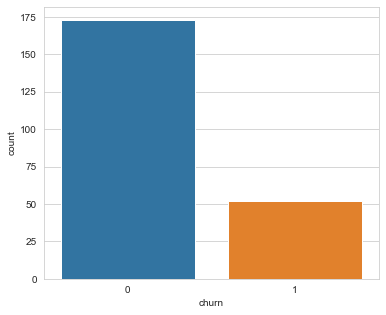

In [39]:
plt.figure(figsize=(6, 5))
sns.countplot(x='churn', data=user_pd)
plt.savefig('dist_churn.png')
plt.show();

### Distributions of Categorical Features

In [40]:
# categorical columns
categorical_cols = user_pd.select_dtypes('object').columns.tolist()
categorical_cols.remove('userId')
categorical_cols

['gender', 'last_level']

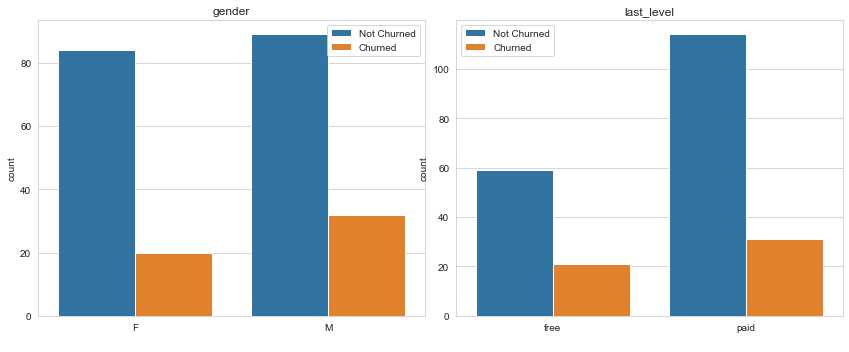

In [41]:
plt.figure(figsize=(12,5))

for i in range(len(categorical_cols)):
    plt.subplot(1,2,i+1)
    plt.tight_layout()
    sns.countplot(x=categorical_cols[i], data=user_pd, hue='churn')
    plt.legend(['Not Churned','Churned'])
    plt.title(categorical_cols[i])
    plt.xlabel(' ')

plt.savefig('dist_categorical.png')
plt.show();

### Correlations among Numerical Features

In [42]:
# a funciton to plot correlations among columns
def plot_corr(cols, figsize=(10,10), filename=None, df=user_pd):
    plt.figure(figsize=figsize)
    sns.heatmap(df[cols].corr(),
                square=True, cmap='YlGnBu', annot=True,
                vmin=-1, vmax=1)
    plt.ylim(len(cols), 0)
    if filename:
        plt.savefig(filename)
    plt.show();

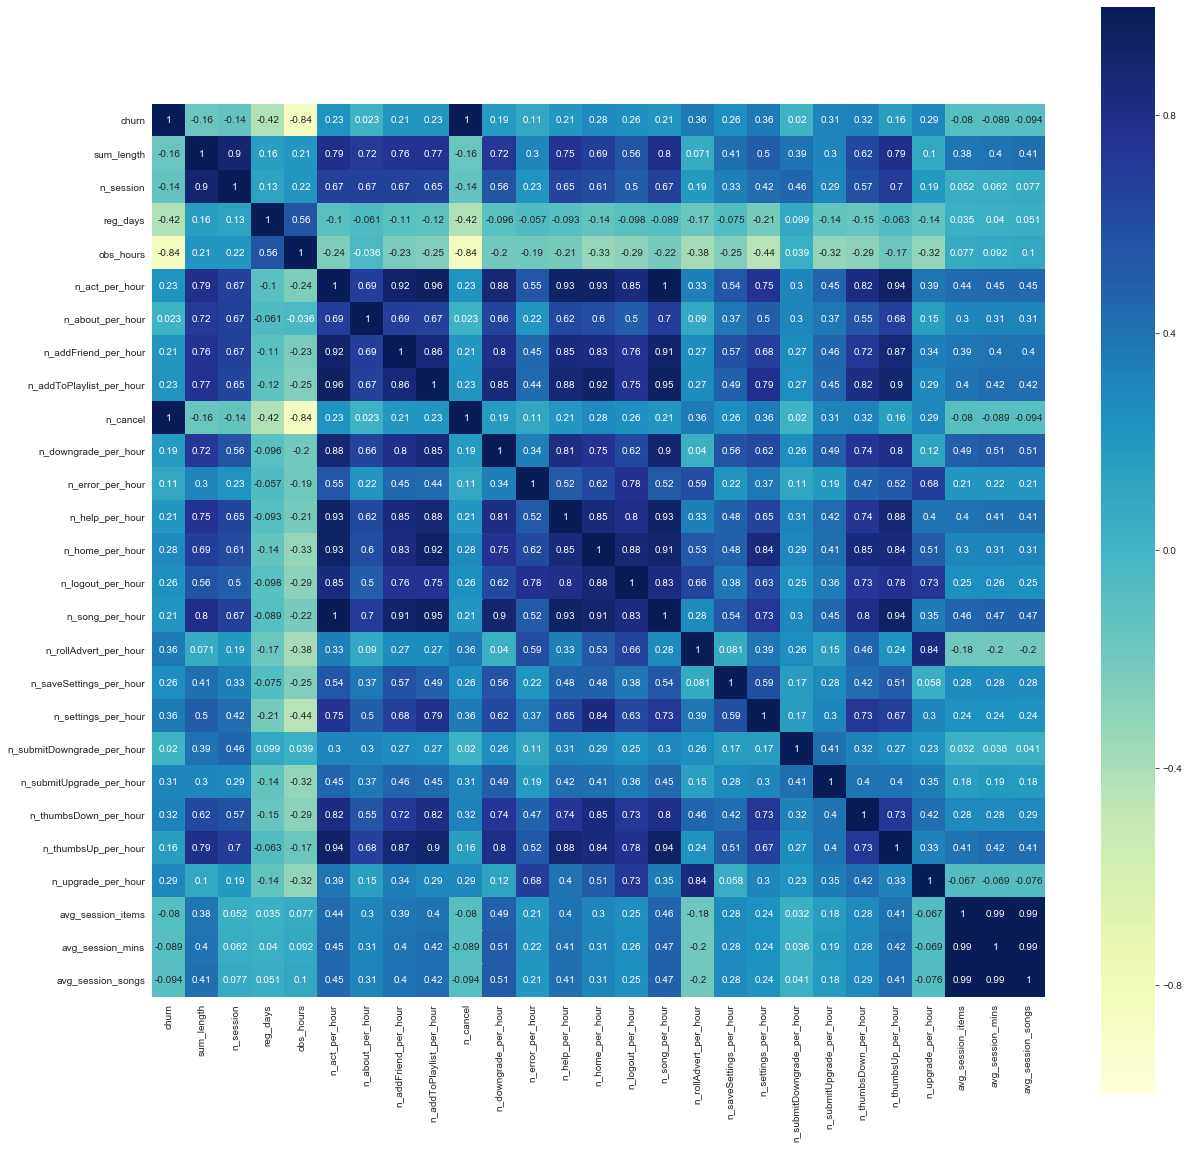

In [43]:
# correlations between numerical features
numerical_cols = user_pd.select_dtypes(include=np.number).columns.tolist()
plot_corr(numerical_cols, figsize=(20,20), filename='corr_full.png')

Highly correlated (>0.8) variable pairs(groups):

- churn, obs_hours, n_cancel
- sum_length, n_session
- n_act_per_hour, n_addFriend_per_hour, n_addToPlaylist_per_hour, n_downgrade_per_hour, 
  n_help_per_hour, n_home_per_hour, n_song_per_hour, n_thumbsUp_per_hour
- avg_session_items, avg_session_mins, avg_session_songs

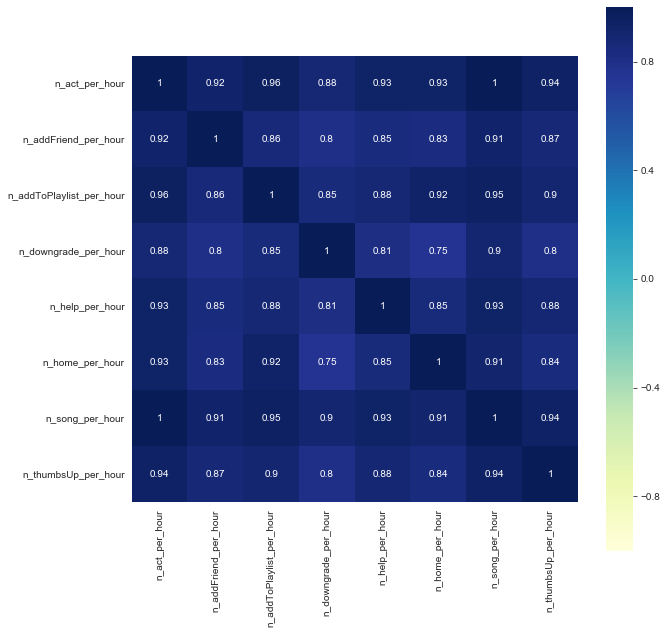

In [44]:
cols = ['n_act_per_hour', 'n_addFriend_per_hour', 'n_addToPlaylist_per_hour', 'n_downgrade_per_hour',
        'n_help_per_hour', 'n_home_per_hour', 'n_song_per_hour', 'n_thumbsUp_per_hour']
plot_corr(cols, filename='corr_n_event_per_hour.png')

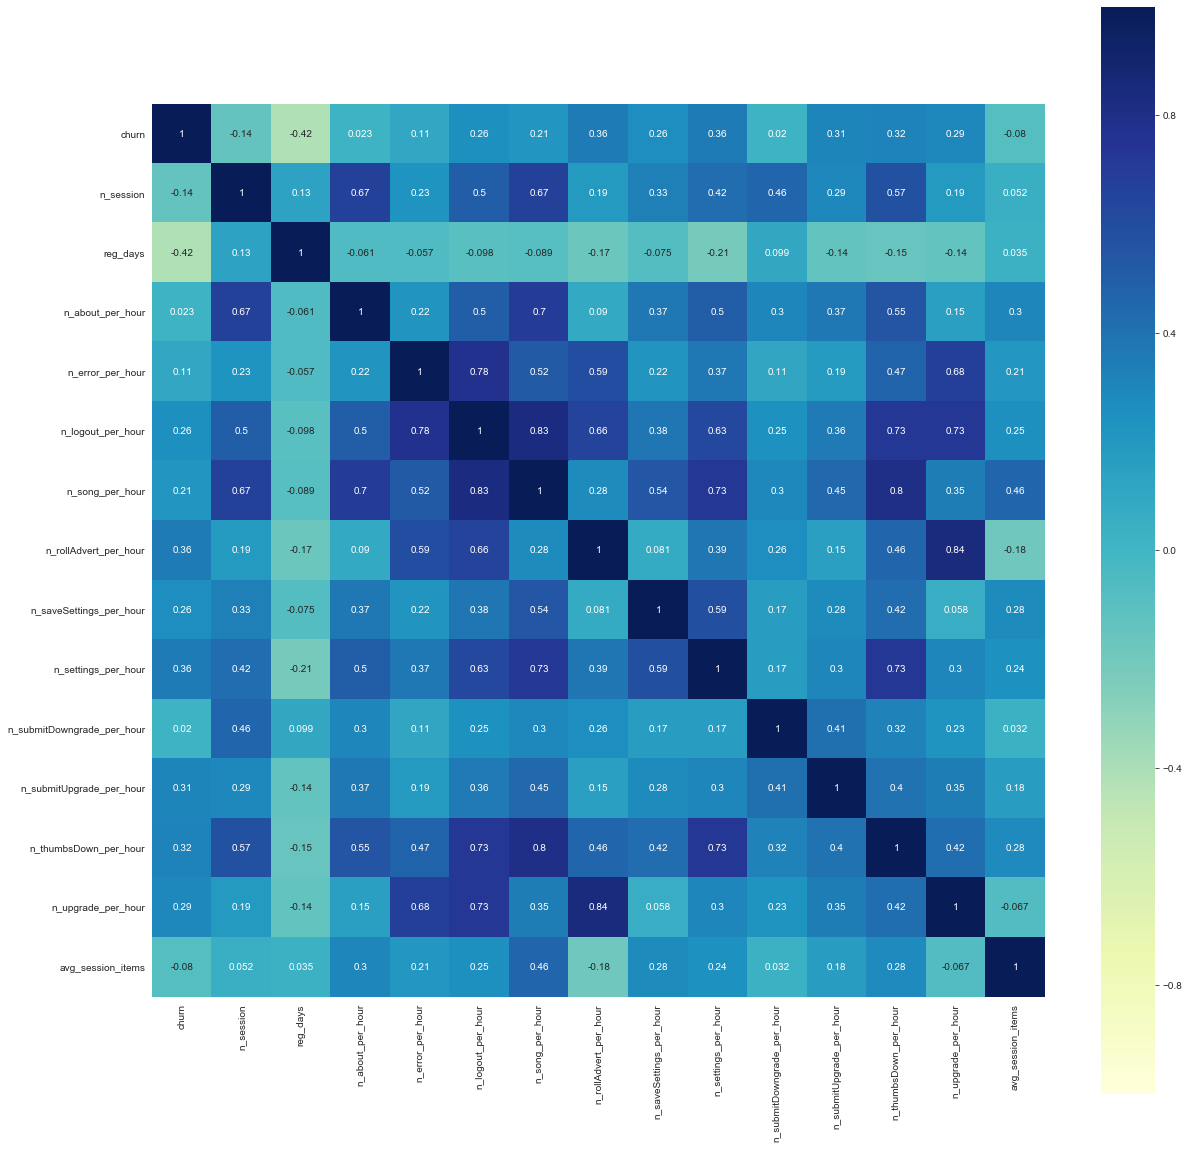

In [45]:
# correlations between numerical features after removing highly correlated columns
drop_cols = ['obs_hours', 'n_cancel', 'sum_length', 'n_act_per_hour', 'n_addFriend_per_hour',
             'n_addToPlaylist_per_hour', 'n_downgrade_per_hour', 'n_help_per_hour',
             'n_home_per_hour', 'n_thumbsUp_per_hour', 'avg_session_mins' , 'avg_session_songs']
numerical_cols = [col for col in numerical_cols if col not in drop_cols]
plot_corr(numerical_cols, figsize=(20,20), filename='corr_numerical.png')

### Distributions of Numerical Features

In [46]:
numerical_cols.remove('churn')

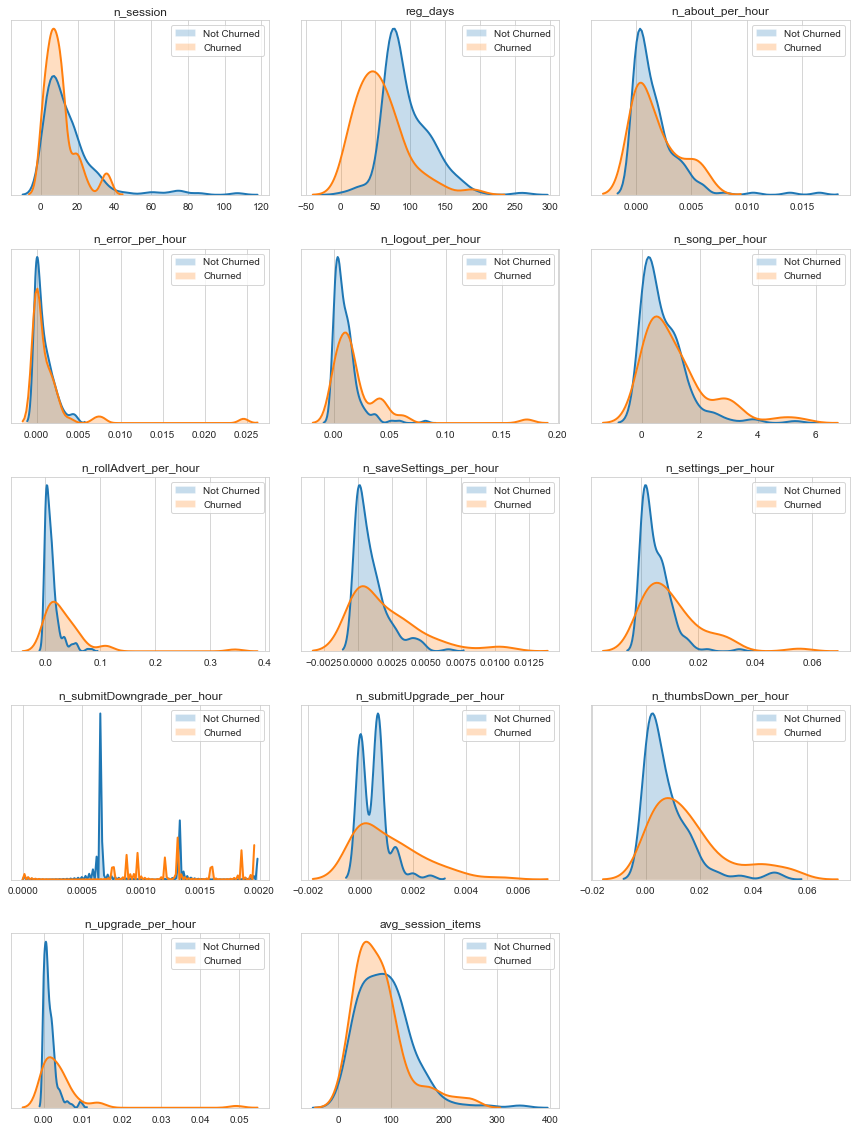

In [47]:
plt.figure(figsize=(12,16))

for i in range(len(numerical_cols)):
    plt.subplot(5,3,i+1)
    plt.tight_layout()
    sns.distplot(user_pd[user_pd['churn']==0][numerical_cols[i]],
                 hist=False, norm_hist=True, kde_kws={'shade': True, 'linewidth': 2})
    sns.distplot(user_pd[user_pd['churn']==1][numerical_cols[i]],
                 hist=False, norm_hist =True, kde_kws={'shade': True, 'linewidth': 2})
    plt.legend(['Not Churned','Churned'])
    plt.title(numerical_cols[i])
    plt.xlabel(' ')
    plt.yticks([])

plt.savefig('dist_numerical.png')
plt.show();

# Feature Engineering
Now we have 16 features in total (excluding the `userId` and `label(churn)` columns).

In [48]:
reserve_cols = [col for col in user_df.columns if col not in drop_cols]
user_df = user_df.select(*reserve_cols).withColumnRenamed('churn', 'label')
user_df.persist();
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- last_level: string (nullable = true)
 |-- n_session: long (nullable = false)
 |-- reg_days: integer (nullable = true)
 |-- n_about_per_hour: double (nullable = true)
 |-- n_error_per_hour: double (nullable = true)
 |-- n_logout_per_hour: double (nullable = true)
 |-- n_song_per_hour: double (nullable = true)
 |-- n_rollAdvert_per_hour: double (nullable = true)
 |-- n_saveSettings_per_hour: double (nullable = true)
 |-- n_settings_per_hour: double (nullable = true)
 |-- n_submitDowngrade_per_hour: double (nullable = true)
 |-- n_submitUpgrade_per_hour: double (nullable = true)
 |-- n_thumbsDown_per_hour: double (nullable = true)
 |-- n_upgrade_per_hour: double (nullable = true)
 |-- avg_session_items: double (nullable = true)



In [49]:
user_df.limit(5).toPandas()

,userId,label,gender,last_level,n_session,reg_days,n_about_per_hour,n_error_per_hour,n_logout_per_hour,n_song_per_hour,n_rollAdvert_per_hour,n_saveSettings_per_hour,n_settings_per_hour,n_submitDowngrade_per_hour,n_submitUpgrade_per_hour,n_thumbsDown_per_hour,n_upgrade_per_hour,avg_session_items
0,100010,0,F,free,7,67,0.000661,0.000000,0.003304,0.181739,0.034365,0.000000,0.000000,0.0,0.000000,0.003304,0.001322,54.428571
1,200002,0,M,paid,6,87,0.001983,0.000000,0.003304,0.255757,0.004626,0.000000,0.001983,0.0,0.000661,0.003965,0.001322,80.000000
2,125,1,M,free,1,71,0.000000,0.000000,0.000000,0.029789,0.003724,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,10.000000
3,124,0,F,paid,29,134,0.004626,0.003965,0.038991,2.695692,0.002643,0.003965,0.013217,0.0,0.000000,0.027096,0.000000,170.137931
4,51,1,M,paid,10,19,0.005107,0.002553,0.061283,5.390342,0.000000,0.002553,0.030641,0.0,0.000000,0.053623,0.000000,251.900000


In [50]:
categorical_cols

['gender', 'last_level']

In [51]:
numerical_cols

['n_session',
 'reg_days',
 'n_about_per_hour',
 'n_error_per_hour',
 'n_logout_per_hour',
 'n_song_per_hour',
 'n_rollAdvert_per_hour',
 'n_saveSettings_per_hour',
 'n_settings_per_hour',
 'n_submitDowngrade_per_hour',
 'n_submitUpgrade_per_hour',
 'n_thumbsDown_per_hour',
 'n_upgrade_per_hour',
 'avg_session_items']

In normal cases of feature engineering, we will have to encode, scale and assemble them as a feature vector before feeding them to our models. But since we use pipeline to build models this time, instead of processing them right now, we will just prepare them as some data-process stages.

In [52]:
# build data-process stages to encode, scale and assemble features
stages = []

# encode categorical features
for col in categorical_cols:
    indexer = FT.StringIndexer(inputCol=col, outputCol=col+'_idx')
    encoder = FT.OneHotEncoderEstimator(inputCols=[indexer.getOutputCol()], outputCols=[col+'_vec'])
    stages += [indexer, encoder]

# scale numeric features
for col in numerical_cols: 
    assembler = FT.VectorAssembler(inputCols=[col], outputCol=col+'_vec')
    scaler = FT.StandardScaler(inputCol=col+'_vec', outputCol=col+'_scl')
    stages += [assembler, scaler]

# assemble features
input_cols = [c+'_vec' for c in categorical_cols] + [c+'_scl' for c in numerical_cols]
assembler = FT.VectorAssembler(inputCols=input_cols, outputCol='features')
stages += [assembler]

# Modeling

## Split Data into Train and Test sets

From the distribution of churn shown in the previous session, we know that this is an unbalanced dataset with only 1/4 of users labeled as churn. To avoid unbalanced results in random split, we first make a train set with sampling by label, then subtract them from the whole dataset to get the test set.

In [53]:
# prepare training and test data, sample by label
ratio = 0.7
train = user_df.sampleBy('label', fractions={0:ratio, 1:ratio}, seed=123)
test = user_df.subtract(train)

In [54]:
print('train set:')
train.groupBy('label').count().show()
print('test set:')
test.groupBy('label').count().show()

train set:
+-----+-----+
|label|count|
+-----+-----+
|    1|   38|
|    0|  125|
+-----+-----+

test set:
+-----+-----+
|label|count|
+-----+-----+
|    1|   14|
|    0|   48|
+-----+-----+



## Model Selection

In order to select a good model for the final tuning, we compare three different classifier models in Spark's MLlib.

- Because the evaluators provided by Spark don’t fit our usage very well, we make a custom evaluate method to peek at the scores when testing prototypes.

In [55]:
def fit_predict(pipeline):
    # fit on train set
    start = time.time()
    model = pipeline.fit(train)
    end = time.time()
    print(f'train time: {end-start:.0f}s')

    # predict on test set
    pred_train = model.transform(train)
    pred_test = model.transform(test)

    return model, pred_train, pred_test

In [56]:
def evaluate(pred, beta=1):
    # true positive
    tp = pred.filter((pred.prediction==1)&(pred.label==1)).count()
    # false positive
    fp = pred.filter((pred.prediction==1)&(pred.label==0)).count()
    # false negative
    fn = pred.filter((pred.prediction==0)&(pred.label==1)).count()
    # true negative
    tn = pred.filter((pred.prediction==0)&(pred.label==0)).count()

    # calculate scores
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    precision = tp/(tp+fp) if (tp+fp)!=0 else 0
    recall = tp/(tp+fn) if (tp+fn)!=0 else 0
    f_beta = (1+beta**2)*(precision*recall)/(beta**2*precision+recall) if (precision+recall)!=0 else 0

    print(f'f{beta}-score:{f_beta:.2f}', )
    print(f'precision:{precision:.2f}')
    print(f'recall:{recall:.2f}')
    print(f'accuracy:{accuracy:.2f}')
    print('confusion matrix:')
    print(f'TP:{tp:.1f}\t | FP:{fp:.1f}')
    print(f'FN:{fn:.1f}\t | TN:{tn:.1f}')

In [57]:
# try different models with default params
lr = LogisticRegression(maxIter=10)
dtc = DecisionTreeClassifier(seed=2)
rfc = RandomForestClassifier(seed=3)

pipelines = [
    Pipeline(stages=stages+[lr]),
    Pipeline(stages=stages+[dtc]),
    Pipeline(stages=stages+[rfc]),
]

for model, pipeline in zip([lr, dtc, rfc], pipelines):
    print('\n', type(model))
    model, pred_train, pred_test = fit_predict(pipeline)
    print('{:-^30}'.format('pred_train'))
    evaluate(pred_train)
    print('{:-^30}'.format('pred_test'))
    evaluate(pred_test)


 <class 'pyspark.ml.classification.LogisticRegression'>
train time: 30s
----------pred_train----------
f1-score:0.88
precision:0.91
recall:0.84
accuracy:0.94
confusion matrix:
TP:32.0	 | FP:3.0
FN:6.0	 | TN:122.0
----------pred_test----------
f1-score:0.75
precision:0.90
recall:0.64
accuracy:0.90
confusion matrix:
TP:9.0	 | FP:1.0
FN:5.0	 | TN:47.0

 <class 'pyspark.ml.classification.DecisionTreeClassifier'>
train time: 23s
----------pred_train----------
f1-score:0.93
precision:1.00
recall:0.87
accuracy:0.97
confusion matrix:
TP:33.0	 | FP:0.0
FN:5.0	 | TN:125.0
----------pred_test----------
f1-score:0.62
precision:0.60
recall:0.64
accuracy:0.82
confusion matrix:
TP:9.0	 | FP:6.0
FN:5.0	 | TN:42.0

 <class 'pyspark.ml.classification.RandomForestClassifier'>
train time: 27s
----------pred_train----------
f1-score:0.88
precision:1.00
recall:0.79
accuracy:0.95
confusion matrix:
TP:30.0	 | FP:0.0
FN:8.0	 | TN:125.0
----------pred_test----------
f1-score:0.64
precision:0.64
recall:0.64
acc

Based on the F1-scores from the test set, we decide to use `LogisticRegression` for final tuning.

## Model Tuning with Stratified Cross-Validation

Since the churned users are a fairly small subset, we will use f1-score as the main metric to optimize.

As mentioned above, Spark's evaluators don't quite fit our usage, so we need to build a `FbetaScore` evaluator class in order to use the cross-validator.

In [58]:
#  Custom F-beta score evaluator
class FbetaScore(Evaluator):

    def __init__(self, beta=1, predictionCol='prediction', labelCol='label'):
        self.predictionCol = predictionCol
        self.labelCol = labelCol
        self.beta = beta

    def _evaluate(self, pred):
        tp = pred.filter((pred.prediction==1)&(pred.label==1)).count()
        fp = pred.filter((pred.prediction==1)&(pred.label==0)).count()
        fn = pred.filter((pred.prediction==0)&(pred.label==1)).count()
        tn = pred.filter((pred.prediction==0)&(pred.label==0)).count()
        
        precision = tp/(tp+fp) if (tp+fp)!=0 else 0
        recall = tp/(tp+fn) if (tp+fn)!=0 else 0
        
        f_beta = (1+self.beta**2)*(precision*recall)/(self.beta**2*precision+recall) if (precision+recall)!=0 else 0

        return f_beta

    def isLargerBetter(self):
        return True

Because PySpark's [`CrossValidator`](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) supports only simple K-fold CV for now, we will use a pip library [`spark-stratifier`](https://github.com/interviewstreet/spark-stratifier) to perform Stratified K-fold CV for our unbalanced dataset.

In [59]:
lr = LogisticRegression()
print(lr.explainParams())

pipeline = Pipeline(stages=stages+[lr])
param_grid = (ParamGridBuilder().addGrid(lr.maxIter,[10, 50, 100])
                                .build())
# evaluator = BinaryClassificationEvaluator()
evaluator = FbetaScore(beta=1)

cv = StratifiedCrossValidator(estimator=pipeline, estimatorParamMaps=param_grid,
                              evaluator=evaluator, numFolds=3, seed=123)
# cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid,
#                     evaluator=evaluator, numFolds=3)

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

In [60]:
# fit, predict and evaluate (lr-elasticNetParam)
cv_model, pred_train, pred_test = fit_predict(cv)
print('{:-^30}'.format('pred_train'))
evaluate(pred_train)
print('{:-^30}'.format('pred_test'))
evaluate(pred_test)

train time: 3113s
----------pred_train----------
f1-score:0.88
precision:0.91
recall:0.84
accuracy:0.94
confusion matrix:
TP:32.0	 | FP:3.0
FN:6.0	 | TN:122.0
----------pred_test----------
f1-score:0.75
precision:0.90
recall:0.64
accuracy:0.90
confusion matrix:
TP:9.0	 | FP:1.0
FN:5.0	 | TN:47.0


No improvement is observed compared with the prototype…Maybe the prototype `LogisticRegression` is already the best ;)

In [62]:
# save best model
cv_model.bestModel.save('./lr_model')

## Feature Importances

In [63]:
feat_imp = cv_model.bestModel.stages[-1].featureImportances.toArray()
feat_imp_pd = pd.DataFrame({'feature':categorical_cols+numerical_cols, 'importance':feat_imp})
feat_imp_pd

,feature,importance
0,gender,0.009475
1,last_level,0.008173
2,n_session,0.032193
3,reg_days,0.322591
4,n_about_per_hour,0.016354
5,n_error_per_hour,0.013207
6,n_logout_per_hour,0.034672
7,n_song_per_hour,0.065007
8,n_rollAdvert_per_hour,0.070714
9,n_saveSettings_per_hour,0.037119


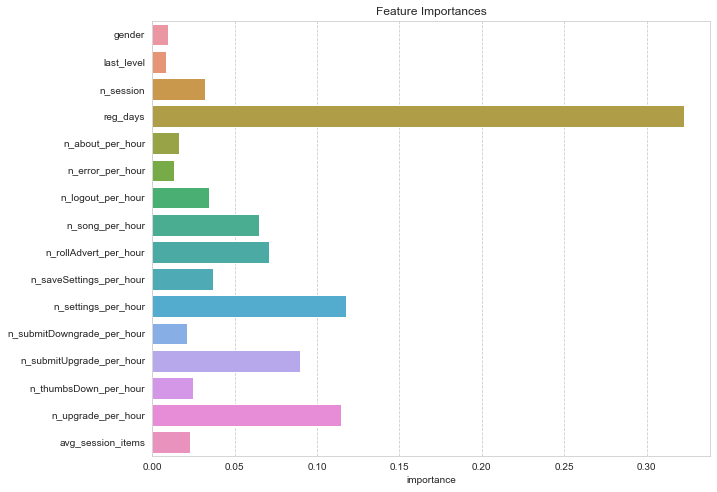

In [64]:
plt.figure(figsize=(10,8))
sns.barplot(data=feat_imp_pd, y='feature', x='importance', zorder=2);
plt.grid(axis='x', linestyle='--', zorder=0)
plt.title('Feature Importances')
plt.ylabel('')
plt.savefig('feat_imp.png')
plt.show();

Top feature importances:

1. reg_days (days after registration)

    Users with shorter registration days are more likely to churn.
    
    _*Same conclusion can be drawn from the distributions of numerical features in the data exploration session._

1. setting-checking events per hour

    The more oftern users checking settings, the more likely they are to churn!

1. upgrade-related events per hour
1. ads watched per hour
1. songs played per hour

# Improvements

- actually predict which users are more likely to churn given some logs as input
- explore more parameters in model tuning session
- a more automatic approach to filter out highly-related features